In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from scipy.stats import sem
import matplotlib.cm as cm

In [3]:
plt.rcParams['font.family'] = 'sans-serif'

In [4]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

# Helper functions

In [5]:
from sklearn.metrics import auc

In [51]:
def plot(
    df, plot_key, plot_ep, figsize=(6.4*0.75, 4.8*0.75),
    fnames=None, figname=None, labels=None,
    smooth_plot=True, smooth_plot_n=2, colors=None,
    legend_title=None, ylim=None, plot_title=None, show_legend=True,
    plot_auc=False, ylabel='Avg Episode Score', xlim=None):
    
    fig, ax = plt.subplots(figsize=figsize)
    zs = np.sort(np.unique(df['z']))
    episode = np.sort(np.unique(df['episode']))
    if fnames is None:
        fnames = np.unique(df['model'])
    for fname_idx, fname in enumerate(fnames):
        line = []
        shading_width = []
        shading_lower = []
        shading_upper = []
        for z in zs:
            df_subset = df[(df['model']==fname) & (df['z']==z)]
            if plot_auc:
                aucs = []
                for file in np.unique(df_subset['file']):
                    df_file_subset = df_subset[df_subset['file']==file]
                    episodes = np.array(df_file_subset['episode'])
                    vals = np.array(df_file_subset[plot_key])
                    aucs.append(auc(episodes, vals)/episodes.max())
                auc_mean = np.mean(aucs)
                auc_sem = sem(aucs)
                line.append(auc_mean)
                shading_width.append(auc_sem)
            else:
                means = []
                sems = []
                for ep in episode:
                    vals = df_subset[df_subset['episode']==ep]
                    vals = vals[plot_key]
                    means.append(np.mean(vals))
                    sems.append(sem(vals))
                means = np.array(means)
                sems = np.array(sems)
                line.append(means[plot_ep])
                shading_width.append(sems[plot_ep])
        if smooth_plot:
            _line = smooth(zs, line, smooth_plot_n)
            _shading_width = smooth(zs, shading_width, smooth_plot_n)
            line = np.array(_line)
            shading_lower = line - _shading_width
            shading_upper = line + _shading_width
        x_axis = zs
        if colors is not None:
            color = colors[fname_idx]
        else:
            color = None
        if labels != None:
            label = fname_labels[fname_idx]
        else:
            label = fname
        ax.plot(x_axis, line, label=label, color=color, alpha=0.8)
        ax.fill_between(x_axis, shading_lower, shading_upper, alpha=0.2,color=color)
    plt.ylabel(ylabel)
    plt.xlabel('Latent Dimensions')
    if show_legend:
        plt.legend(title=legend_title, fontsize=12, title_fontsize=12)
    if ylim != None:
        plt.ylim(ylim[0], ylim[1])
    if xlim != None:
        plt.xlim(xlim[0], xlim[1])
    if plot_title != None:
        plt.title(plot_title)
    plt.xlabel('Latent Size')
    plt.tight_layout()
    if figname != None:
        plt.savefig(figname+'.png', dpi=300)
    plt.show()

In [61]:
def smooth(xs, ys, n=3):
    vals = np.copy(ys)
    smoothed = np.convolve(ys, np.ones(n)/n, mode='same')
    vals[1:-1] = smoothed[1:-1]
    return vals

In [8]:
def get_df(base, zs, net_yaml):
    data = {
        'valid_score': [], 'valid_steps':[], 'dims': [],
        'episode': [], 'model': [], 'z': [], 'step': [], 'file': []}
    for z in zs:
        task_dir = f'{base}_{net_yaml}_dim{z}'
        task_dir = f'{engram_dir}pickles/{task_dir}/'
        if not os.path.exists(task_dir): continue
        for pickle_file in os.listdir(task_dir):
            if not pickle_file.endswith('.p'): continue
            pickle_file = f'{task_dir}{pickle_file}'
            with open(pickle_file, 'rb') as f:
                results = pickle.load(f)
            valid_score = results['valid_score']
            valid_steps = results['valid_steps_per_ep']
            episode = results['episode']
            model = results['model']
            step = results['step']
            for i in range(len(valid_score)):
                if valid_score[i] == None: continue
                data['valid_score'].append(valid_score[i])
                data['valid_steps'].append(valid_steps[i])
                data['dims'].append(z)
                data['episode'].append(episode[i])
                _model = model[i].split(base+'_')[-1]
                data['model'].append(_model)
                data['z'].append(z)
                data['step'].append(step[i])
                data['file'].append(pickle_file)
    df = pd.DataFrame(data)
    return df

# Initial Gridworld Experiments

In [35]:
zs = np.arange(2, 13)

In [36]:
task_df = get_df('new_gridworld8x8_shuffobs', zs, 'dm')

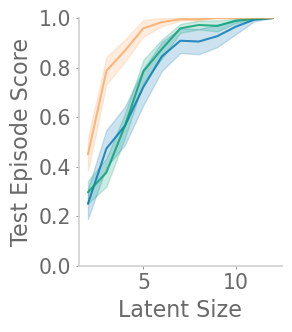

In [39]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, figsize=(6.4*0.5, 4.8*0.75),
    fnames=['mf0', 'entro0', 'g0_-2_entro-1'],
    smooth_plot=True, smooth_plot_n=2,
    figname='gridworld6x6_taskA_early',
    colors=['C0', 'C2', colors(c_steps[0])],
    show_legend=False,
    plot_title='', ylim=(0,1), ylabel='Test Episode Score'
    )

# Transfer Experiments with $\gamma$ (Task B)

In [40]:
zs = np.arange(2, 22)

In [41]:
task_df = get_df('frozentransfer_new_gridworld8x8_shuffobs', zs, 'dm_large_q')

In [42]:
np.unique(task_df['model'])

array(['entro2', 'g0.25_-2_entro0', 'g0.5_-2_entro0', 'g0.8_-4_entro0',
       'g0_-2_entro-1', 'mf0'], dtype=object)

In [47]:
def smooth(xs, ys, n=3):
    vals = np.copy(ys)
    smoothed = np.convolve(ys, np.ones(n)/n, mode='same')
    return smoothed

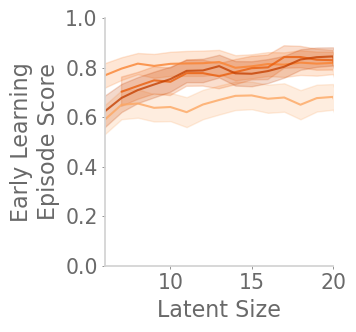

In [55]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 100, figsize=(6.4*0.6, 4.8*0.75),
    fnames=['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0', 'g0.5_-2_entro0', 'g0.8_-4_entro0'],
    show_legend=False,
    smooth_plot=True, smooth_plot_n=4, figname='gridworld6x6_taskA_early',
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='', ylim=(0,1), ylabel='Early Learning\nEpisode Score', xlim=[6,20]
    )

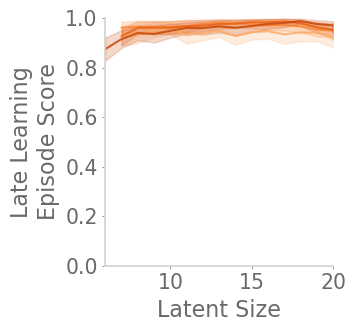

In [56]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, figsize=(6.4*0.6, 4.8*0.75),
    fnames=['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0', 'g0.5_-2_entro0', 'g0.8_-4_entro0'],
    show_legend=False,
    smooth_plot=True, smooth_plot_n=4, figname='gridworld6x6_taskA_early',
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='', ylim=(0,1), ylabel='Late Learning\nEpisode Score', xlim=[6,20]
    )

# Transfer Experiments with $\gamma$ (Task A)

In [62]:
zs = np.arange(2, 22)

In [63]:
task_df = get_df('new_gridworld8x8_shuffobs', zs, 'dm_large_q')

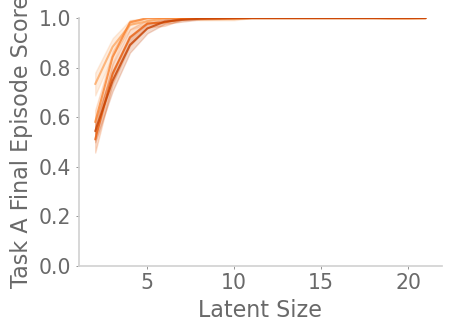

In [64]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, show_legend=False,
    fnames=['mf', 'entro', 'g0_-2_entro-1', 'g0.25_-2_entro0', 'g0.5_-2_entro0', 'g0.8_-4_entro0'],
    smooth_plot=True, smooth_plot_n=3, figname='gridworld6x6_taskA_early',
    colors=['C0', 'C2']+[colors(i) for i in c_steps],
    plot_title='', ylim=(0,1), ylabel='Task A Final Episode Score'
    )

# Effect of Large Q

In [28]:
zs = np.arange(2, 22)

In [29]:
task_df = get_df('new_gridworld8x8_shuffobs', zs, 'dm_large_q')

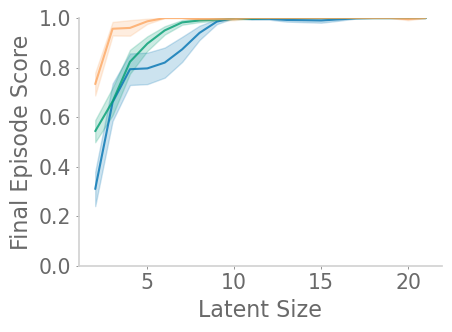

In [30]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, show_legend=False,
    fnames=['mf0', 'entro2', 'g0_-2_entro-1'], 
    smooth_plot=True, smooth_plot_n=3, figname='',
    colors=['C0', 'C2', colors(c_steps[0])],
    plot_title='', ylim=(0,1), ylabel='Final Episode Score'
    )

# Effect of Large Encoder

In [31]:
zs = np.arange(2, 22)

In [32]:
task_df = get_df('new_gridworld8x8_shuffobs', zs, 'dm_large_encoder')

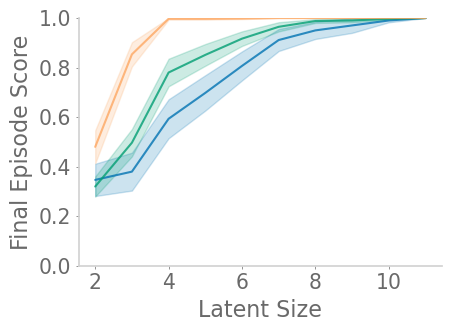

In [33]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score', 600, show_legend=False,
    fnames=['mf1', 'entro0', 'g0_-2_entro-1'],
    smooth_plot=True, smooth_plot_n=3, figname='',
    colors=['C0', 'C2', colors(c_steps[0])],
    plot_title='', ylim=(0,1), ylabel='Final Episode Score'
    )